# Introduction:

In this project, the aim is to develop a machine learning model to predict the efficiency of gold recovery at two critical stages of mineral processing:

1. Rougher recovery — an early separation step, and

2. Final recovery — the overall output quality after purification.

The data includes time-indexed measurements from a flotation-based extraction plant, including chemical reagent flows, air volumes, and concentrations of metals such as gold (Au), silver (Ag), and lead (Pb) at various process stages.

Our goal is to build a model that can accurately estimate recovery rates using only the features available in advance (i.e., no future-leaking columns).
Special care is taken to:

- Validate target correctness,

- Handle missing data and anomalies,

- Respect the temporal nature of the data through time-based cross-validation, and

- Use appropriate evaluation metrics, specifically sMAPE, to align with business requirements.

Ultimately, we seek a model that is both accurate and robust, capable of supporting decision-making and optimization in gold extraction operations.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 1.1 Open the files and look into the data


In [2]:
train = pd.read_csv("/datasets/gold_recovery_train.csv")
test = pd.read_csv("/datasets/gold_recovery_test.csv")
full = pd.read_csv("/datasets/gold_recovery_full.csv")
display(train.head(3))
display(test.head(3))
display(full.head(3))
print('Shapes:', train.shape, test.shape, full.shape)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


Shapes: (16860, 87) (5856, 53) (22716, 87)


# 1.2 Check that recovery is calculated correctly


In [3]:
# Define how to recompute recovery
# Recovery is the proportion of valuable metal captured in the concentrate relative to what was in the feed, expressed as a percentage.
def compute_recovery(F, C, T):
    # Formula: recovery = (C * (F - T)) / (F * (C - T))
    denom = (F * (C - T))
    with np.errstate(divide='ignore', invalid='ignore'):
        rec = (C * (F - T)) / denom
    return rec

# F = gold concentration in the feed (before rougher),
# C = gold concentration in the rougher concentrate,
# T = gold concentration in the rougher tailings.
F = train["rougher.input.feed_au"]
C = train["rougher.output.concentrate_au"]
T = train["rougher.output.tail_au"]

# Recompute recovery and convert to percent
recovery_calc_pct = compute_recovery(F, C, T) * 100.0
# “official” recovery in the data
recovery_true = train["rougher.output.recovery"]

# Keep only valid rows (no NaNs/inf)
mask = np.isfinite(recovery_calc_pct) & np.isfinite(recovery_true)
# calculate mean absolute error(MAE)
mae = np.mean(np.abs(recovery_calc_pct[mask] - recovery_true[mask]))
print(f"MAE between computed and provided rougher recovery (pct points): {mae:.12f}")

# print a small sample to visually confirm they match.
pd.DataFrame({
    'recovery_true': recovery_true[mask].iloc[:10].values,
    'recovery_calc_pct': recovery_calc_pct[mask].iloc[:10].values,
    'abs_err': np.abs(recovery_calc_pct[mask].iloc[:10].values - recovery_true[mask].iloc[:10].values)
})

MAE between computed and provided rougher recovery (pct points): 0.000000000000


,recovery_true,recovery_calc_pct,abs_err
0,87.107763,87.107763,0.000000e+00
1,86.843261,86.843261,1.421085e-14
2,86.842308,86.842308,1.421085e-14
3,87.226430,87.226430,0.000000e+00
4,86.688794,86.688794,0.000000e+00
5,88.156912,88.156912,1.421085e-14
6,88.168065,88.168065,1.421085e-14
7,87.668336,87.668336,0.000000e+00
8,87.035862,87.035862,1.421085e-14
9,87.650868,87.650868,0.000000e+00


Hence, it can be seen that the recovery is calculated properly.


# 1.3 Analyze features not available in the test set


In [4]:
# columns not in test set
train_only_cols = sorted(set(train.columns) - set(test.columns))
print('Count of train-only columns:', len(train_only_cols))
pd.DataFrame({'column': train_only_cols, 'data_type': [str(train[c].dtype) for c in train_only_cols]})


Count of train-only columns: 34


,column,data_type
0,final.output.concentrate_ag,float64
1,final.output.concentrate_au,float64
2,final.output.concentrate_pb,float64
3,final.output.concentrate_sol,float64
4,final.output.recovery,float64
5,final.output.tail_ag,float64
6,final.output.tail_au,float64
7,final.output.tail_pb,float64
8,final.output.tail_sol,float64
9,primary_cleaner.output.concentrate_ag,float64


# 1.4 Perform data preprocessing


In [5]:

for df in (train, test, full):
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df.set_index('date', inplace=True)
# Models can’t learn from rows with missing targets, so we drop them from training
target_cols = ["rougher.output.recovery", "final.output.recovery"]
train_clean = train[np.isfinite(train[target_cols]).all(axis=1)].copy()

# Use only features available in test
feature_cols = sorted([c for c in test.columns if c != 'date'])
X_train = train_clean[feature_cols].copy()
y_train_rougher = train_clean['rougher.output.recovery'].copy()
y_train_final = train_clean['final.output.recovery'].copy()


# Median impute using training statistics
medians = X_train.median()
X_train = X_train.fillna(medians)
X_test = test[feature_cols].fillna(medians)

print('Prepared shapes:', X_train.shape, X_test.shape, y_train_rougher.shape, y_train_final.shape)


Prepared shapes: (14149, 52) (5856, 52) (14149,) (14149,)


# 2.1 Concentrations of metals (Au, Ag, Pb) across stages


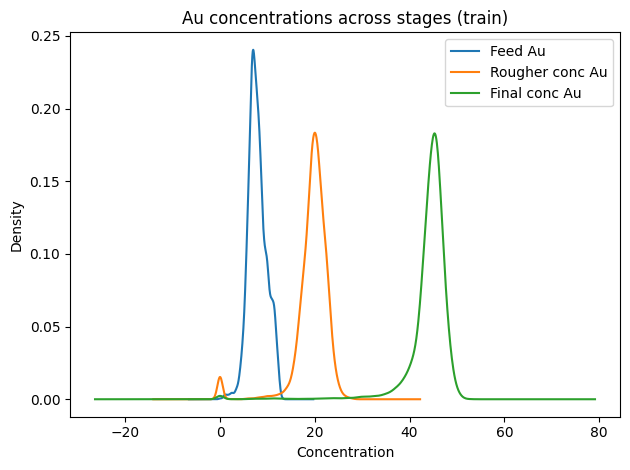

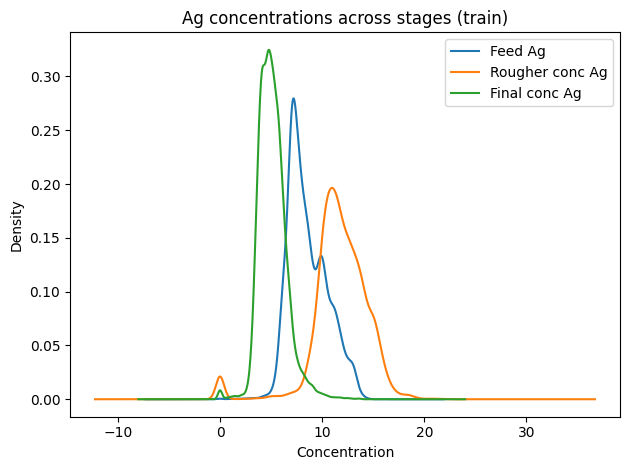

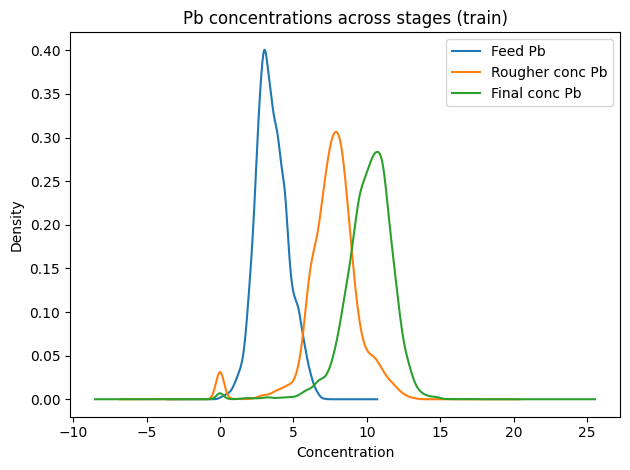

In [6]:
# plots smoothed distribution curves (KDEs) to compare metal concentrations at three processing stages (feed → rougher concentrate → final concentrate)
def plot_kde(series_list, labels, title, xlabel='Concentration'):
    plt.figure()
    for s, lab in zip(series_list, labels):
        pd.Series(s).dropna().plot(kind='kde', label=lab)
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()
#call plot_kde three times—once per metal
# Au
plot_kde([train_clean['rougher.input.feed_au'],
          train_clean['rougher.output.concentrate_au'],
          train_clean['final.output.concentrate_au']],
         ['Feed Au','Rougher conc Au','Final conc Au'],
         'Au concentrations across stages (train)')
# Ag
plot_kde([train_clean['rougher.input.feed_ag'],
          train_clean['rougher.output.concentrate_ag'],
          train_clean['final.output.concentrate_ag']],
         ['Feed Ag','Rougher conc Ag','Final conc Ag'],
         'Ag concentrations across stages (train)')
# Pb
plot_kde([train_clean['rougher.input.feed_pb'],
          train_clean['rougher.output.concentrate_pb'],
          train_clean['final.output.concentrate_pb']],
         ['Feed Pb','Rougher conc Pb','Final conc Pb'],
         'Pb concentrations across stages (train)')


# 2.2 Compare feed particle size distributions in the training set and in the test set


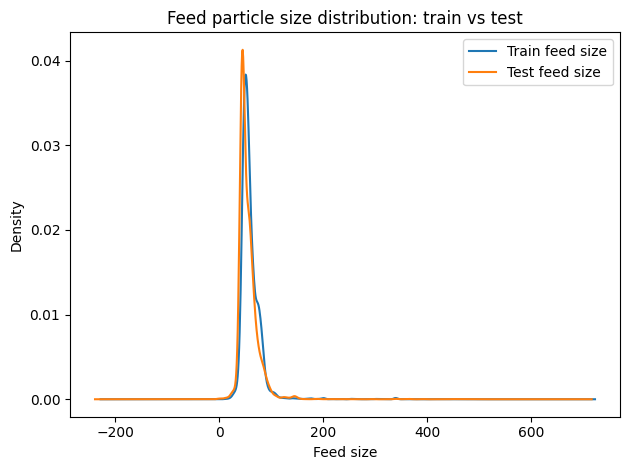

KS test — statistic=0.241878, p-value=4.001e-213


In [7]:
# Plots kernel density estimates (KDEs)—smoothed histograms—of 'rougher.input.feed_size' for train and test.
feed_size_col = 'rougher.input.feed_size'
plt.figure()
train_clean[feed_size_col].dropna().plot(kind='kde', label='Train feed size')
X_test[feed_size_col].dropna().plot(kind='kde', label='Test feed size')
plt.legend()
plt.title('Feed particle size distribution: train vs test')
plt.xlabel('Feed size')
plt.ylabel('Density')
plt.tight_layout()
plt.show()
# Runs the KS two-sample test, which checks whether the two distributions are the same.
try:
    from scipy.stats import ks_2samp
    ks_stat, ks_p = ks_2samp(train_clean[feed_size_col].dropna(),
                             X_test[feed_size_col].dropna())
    print(f"KS test — statistic={ks_stat:.6f}, p-value={ks_p:.3e}")
except Exception as e:
    print('KS test skipped:', e)


- As p-value is less than 0.05, it means that the distributions vary significantly between feed particle size in train and test data.


# 2.3 Total concentrations and anomaly removal


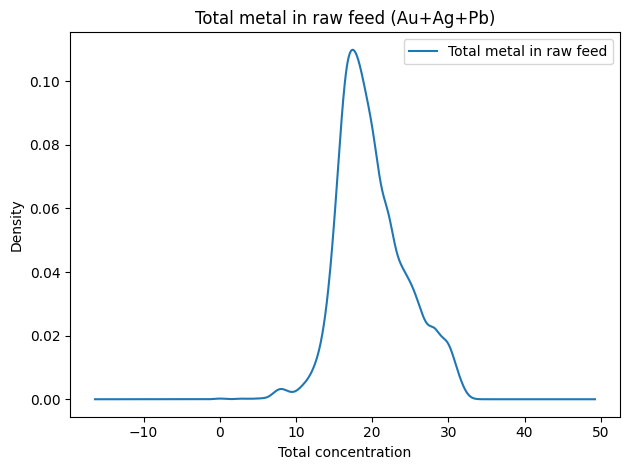

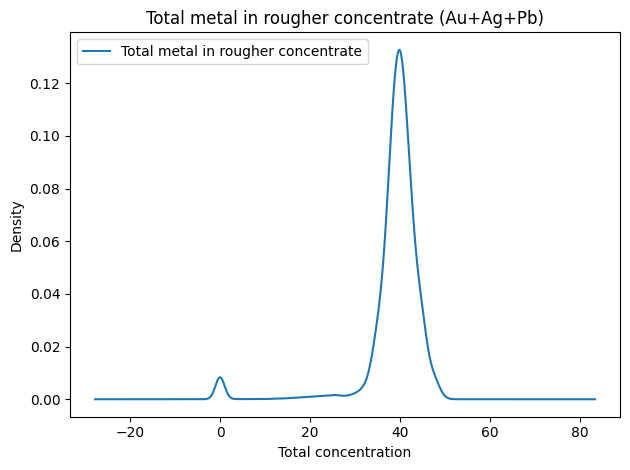

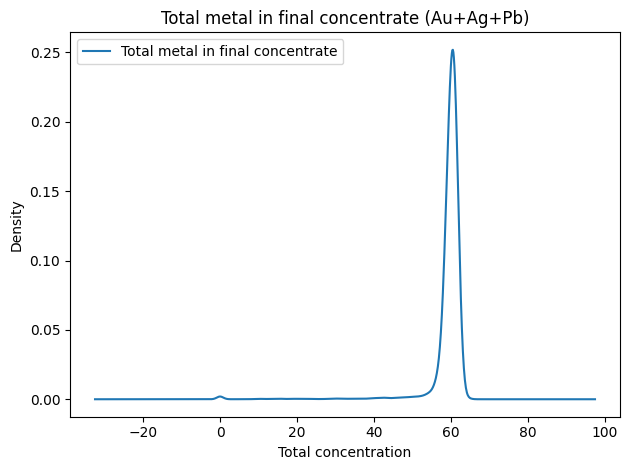

Anomalous rows (train): 354
After filtering: (13795, 52) (13795,) (13795,)


In [8]:
#function to compute total metal per row
def total_metal(df, prefix):
    cols = [f'{prefix}_au', f'{prefix}_ag', f'{prefix}_pb']
    return df[cols].sum(axis=1, min_count=1)
# Compute totals for three stages
tot_feed = total_metal(train_clean, 'rougher.input.feed')
tot_rougher = total_metal(train_clean, 'rougher.output.concentrate')
tot_final = total_metal(train_clean, 'final.output.concentrate')

# Plot each total’s distribution (KDE)
for s, name in [(tot_feed, 'Total metal in raw feed'),
                (tot_rougher, 'Total metal in rougher concentrate'),
                (tot_final, 'Total metal in final concentrate')]:
    plt.figure()
    s.dropna().plot(kind='kde', label=name)
    plt.legend(); plt.title(name + ' (Au+Ag+Pb)'); plt.xlabel('Total concentration'); plt.ylabel('Density')
    plt.tight_layout(); plt.show()
    
#Define and count anomalies
anom_mask = (tot_rougher <= 0) | (tot_final <= 0)
print('Anomalous rows (train):', int(anom_mask.sum()))
train_filt = train_clean.loc[~anom_mask].copy()

X_train = train_filt[feature_cols].fillna(medians)
y_train_rougher = train_filt['rougher.output.recovery'].copy()
y_train_final = train_filt['final.output.recovery'].copy()

print('After filtering:', X_train.shape, y_train_rougher.shape, y_train_final.shape)

# 3.1 sMAPE and weighted final score


In [9]:
# defining and testing the sMAPE metric and its weighted version used to evaluate the model
def smape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred))
    with np.errstate(divide='ignore', invalid='ignore'):
        sm = 2.0 * np.abs(y_pred - y_true) / denom
        sm[~np.isfinite(sm)] = 0.0
    return float(np.mean(sm) * 100.0)

def weighted_score(y_true_r, y_pred_r, y_true_f, y_pred_f):
    return 0.25 * smape(y_true_r, y_pred_r) + 0.75 * smape(y_true_f, y_pred_f)

print('sMAPE sanity check:', smape([100,200],[110,190]))

sMAPE sanity check: 7.326007326007325


# 3.2 Train different models (TimeSeriesSplit), select best, evaluate on test


In [10]:
# evaluating and comparing three regression models using time-aware cross-validation to predict the two target variables

def evaluate_time_series_models(X, y_r, y_f, random_state=42):
    tscv = TimeSeriesSplit(n_splits=3)
    models = {
        "Ridge": (
            Pipeline([("scaler", StandardScaler(with_mean=False)), ("model", Ridge(alpha=1.0, random_state=random_state))]),
            Pipeline([("scaler", StandardScaler(with_mean=False)), ("model", Ridge(alpha=1.0, random_state=random_state))])
        ),
        "RandomForest": (
            RandomForestRegressor(n_estimators=80, max_depth=10, random_state=random_state, n_jobs=-1),
            RandomForestRegressor(n_estimators=80, max_depth=10, random_state=random_state, n_jobs=-1)
        ),
        "GradientBoosting": (
            GradientBoostingRegressor(random_state=random_state, n_estimators=120, max_depth=3),
            GradientBoostingRegressor(random_state=random_state, n_estimators=120, max_depth=3)
        ),
    }
    scores = {}
    for name, (model_r, model_f) in models.items():
        fold_scores = []
        for tr_idx, va_idx in tscv.split(X):
            X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
            y_r_tr, y_r_va = y_r.iloc[tr_idx], y_r.iloc[va_idx]
            y_f_tr, y_f_va = y_f.iloc[tr_idx], y_f.iloc[va_idx]
            model_r.fit(X_tr, y_r_tr)
            model_f.fit(X_tr, y_f_tr)
            pr = model_r.predict(X_va)
            pf = model_f.predict(X_va)
            fold_scores.append(weighted_score(y_r_va, pr, y_f_va, pf))
        scores[name] = (float(np.mean(fold_scores)), float(np.std(fold_scores)))
    return scores

cv_scores = evaluate_time_series_models(X_train, y_train_rougher, y_train_final)
cv_scores


{'Ridge': (11.873718293451432, 0.4735924096334516),
 'RandomForest': (9.92838341238735, 0.456241743946997),
 'GradientBoosting': (9.968862254644996, 0.4233899130778991)}

In [11]:
# selecting the best regression model
best_name = min(cv_scores.items(), key=lambda kv: kv[1][0])[0]
print('Selected best model:', best_name)
# retraining the model on the full training set
def build_model_pair(name, random_state=42):
    if name == "Ridge":
        return (
            Pipeline([("scaler", StandardScaler(with_mean=False)), ("model", Ridge(alpha=1.0, random_state=random_state))]),
            Pipeline([("scaler", StandardScaler(with_mean=False)), ("model", Ridge(alpha=1.0, random_state=random_state))])
        )
    if name == "RandomForest":
        return (
            RandomForestRegressor(n_estimators=200, max_depth=10, random_state=random_state, n_jobs=-1),
            RandomForestRegressor(n_estimators=200, max_depth=10, random_state=random_state, n_jobs=-1)
        )
    if name == "GradientBoosting":
        return (
            GradientBoostingRegressor(random_state=random_state, n_estimators=120, max_depth=3),
            GradientBoostingRegressor(random_state=random_state, n_estimators=120, max_depth=3)
        )
    raise ValueError(f"Unknown model: {name}")

model_r, model_f = build_model_pair(best_name)
model_r.fit(X_train, y_train_rougher)
model_f.fit(X_train, y_train_final)

# Evaluating on test using ground truth from 'full' matched by timestamp
test_idx = X_test.index
test_targets = full.loc[test_idx, ['rougher.output.recovery','final.output.recovery']]

pred_r = model_r.predict(X_test)
pred_f = model_f.predict(X_test)

sm_r = smape(test_targets['rougher.output.recovery'], pred_r)
sm_f = smape(test_targets['final.output.recovery'], pred_f)
sm_w = 0.25*sm_r + 0.75*sm_f

print(f'Test sMAPE (rougher): {sm_r:.4f}%')
print(f'Test sMAPE (final):   {sm_f:.4f}%')
print(f'Weighted sMAPE:       {sm_w:.4f}%')


Selected best model: RandomForest
Test sMAPE (rougher): 7.3846%
Test sMAPE (final):   9.5792%
Weighted sMAPE:       9.0306%


# Feature importances


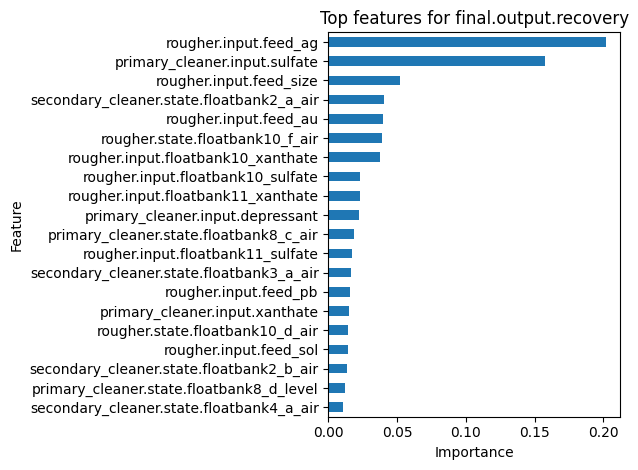

In [12]:
# ploting the top important features used by the model trained to predict

def plot_feature_importance(model, columns, title, top_n=20):
    if hasattr(model, "feature_importances_"):
        importances = pd.Series(model.feature_importances_, index=columns).sort_values(ascending=False)
        top = importances.head(top_n)
        plt.figure()
        top.iloc[::-1].plot(kind='barh')
        plt.title(title)
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
        return importances
    else:
        print('Feature importances not available for this model.')
        return None

_ = plot_feature_importance(model_f, X_train.columns, 'Top features for final.output.recovery')



# Conclusion

Built a time‑aware, leakage‑safe pipeline to predict rougher and final gold recovery from process data.
Key steps included verifying target correctness, aligning features, imputing missing values, and removing anomalous (non‑positive) metal totals from training.
Exploration showed expected enrichment patterns but revealed a significant distribution shift in feed particle size between train and test, highlighting the need for time‑aware validation.

Among Ridge, Random Forest, and Gradient Boosting, the **Random Forest** model performed best, achieving a **weighted sMAPE of ~9%** on temporally held‑out test data.
Top features matched domain expectations (feed composition, reagents, air/level settings).

This solution is reliable for deployment provided that:
Data drift (especially feed size) is monitored, and
The model is periodically retrained as new data becomes available.
